In [150]:
import numpy as np
import networkx as nx
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [162]:
# -------------------------------------------
# 1. Modelo difuso para tráfico y retardos
# -------------------------------------------
hora = ctrl.Antecedent(np.arange(0, 24, 1), 'hora')
trafico = ctrl.Antecedent(np.arange(0, 101, 1), 'trafico')
dens_sem = ctrl.Antecedent(np.arange(0, 101, 1), 'dens_sem')
factor_vel = ctrl.Consequent(np.arange(0.5, 2.01, 0.01), 'factor_vel')
delay     = ctrl.Consequent(np.arange(0, 121,   1), 'delay')

# Membresías
hora['manana']   = fuzz.trimf(hora.universe, [5, 8,11])
hora['mediodia'] = fuzz.trimf(hora.universe, [11,13,15])
hora['tarde']    = fuzz.trimf(hora.universe, [15,18,21])
trafico['bajo']  = fuzz.trimf(trafico.universe, [0,10,30])
trafico['medio'] = fuzz.trimf(trafico.universe, [20,50,80])
trafico['alto']  = fuzz.trimf(trafico.universe, [60,90,100])
dens_sem['pocas']     = fuzz.trimf(dens_sem.universe, [0,10,30])
dens_sem['moderadas'] = fuzz.trimf(dens_sem.universe, [20,50,80])
dens_sem['muchas']    = fuzz.trimf(dens_sem.universe, [60,90,100])
factor_vel['lento']  = fuzz.trimf(factor_vel.universe, [0.5,0.75,1.0])
factor_vel['normal'] = fuzz.trimf(factor_vel.universe, [0.9,1.2,1.5])
factor_vel['rapido'] = fuzz.trimf(factor_vel.universe, [1.3,1.7,2.0])
delay['bajo']   = fuzz.trimf(delay.universe, [0,10,30])
delay['medio']  = fuzz.trimf(delay.universe, [20,40,60])
delay['alto']   = fuzz.trimf(delay.universe, [50,80,120])

# Reglas
rules = [
    ctrl.Rule(hora['manana']   & trafico['alto'],   factor_vel['lento']),
    ctrl.Rule(hora['mediodia'] & trafico['medio'],  factor_vel['normal']),
    ctrl.Rule(hora['tarde']    & trafico['bajo'],   factor_vel['rapido']),
    ctrl.Rule(dens_sem['muchas'],    delay['alto']),
    ctrl.Rule(dens_sem['moderadas'], delay['medio']),
    ctrl.Rule(dens_sem['pocas'],     delay['bajo'])
]

trafico_ctrl   = ctrl.ControlSystem(rules)
sim_factor_vel = ctrl.ControlSystemSimulation(trafico_ctrl)
sim_delay      = ctrl.ControlSystemSimulation(trafico_ctrl)


In [152]:
# -------------------------------------------
# 2. Generador de instancias con depósito
# -------------------------------------------
class InstanceGenerator:
    def __init__(self, n_destinos, deposito, area_size=10):
        """
        n_destinos: número de nodos destino
        deposito: (x, y) del depósito, será nodo 0
        """
        self.n = n_destinos
        self.deposito = np.array(deposito)
        self.area = area_size

    def generate_coordinates(self):
        # Genera sólo destinos (nodos 1..n)
        return np.random.uniform(0, self.area, (self.n, 2))

    def build_dynamic_graph(self, coords):
        G = nx.DiGraph()
        # Nodo 0 = depósito
        G.add_node(0, coord=tuple(self.deposito), delay=0.0)
        # Nodos 1..n = destinos
        for i, (x, y) in enumerate(coords, start=1):
            G.add_node(i, coord=(x, y), delay=0.0)
        # Crear aristas
        for i in G.nodes:
            xi, yi = G.nodes[i]['coord']
            for j in G.nodes:
                if i == j: continue
                xj, yj = G.nodes[j]['coord']
                # Inferencia difusa
                h    = np.random.randint(0,24)
                traf = np.random.randint(0,101)
                dens = np.random.randint(0,101)
                sim_factor_vel.input['hora']    = h
                sim_factor_vel.input['trafico'] = traf
                sim_factor_vel.input['dens_sem']= dens
                sim_factor_vel.compute()
                alpha = sim_factor_vel.output.get('factor_vel',1.0)
                sim_delay.input['hora']    = h
                sim_delay.input['trafico'] = traf
                sim_delay.input['dens_sem']= dens
                sim_delay.compute()
                G.nodes[j]['delay'] = sim_delay.output.get('delay',0.0)
                # Distancia euclidiana base
                dist = np.hypot(xi-xj, yi-yj)
                t_ij = dist * alpha
                G.add_edge(i, j, time=t_ij)
        return G

## Funcion objetivo

In [153]:
# -------------------------------------------
# 3. Función de valoración mejorada
# -------------------------------------------
def route_cost(G, route, alpha=1.0, beta=1.0, gamma=0.5):
    """
    Cálculo de costo con:
     - D: distancia Manhattan total
     - Delta: suma delays
     - P: penalización giros
    """
    D = 0.0
    Delta = 0.0
    P = 0
    prev_dir = None

    for k in range(len(route)-1):
        i, j = route[k], route[k+1]
        x1, y1 = G.nodes[i]['coord']
        x2, y2 = G.nodes[j]['coord']
        # Distancia Manhattan
        d = abs(x1-x2) + abs(y1-y2)
        D += d
        # Delay (except depósito final)
        if j != 0:
            Delta += G.nodes[j]['delay']
        # Giro?
        curr_dir = 'h' if abs(x2-x1)>0 else 'v'
        if prev_dir is not None and curr_dir != prev_dir:
            P += 1
        prev_dir = curr_dir

    return alpha * D + beta * Delta + gamma * P

In [163]:
# ---------------------------
# 4. PSO con historial
# ---------------------------
class PSO_TSP:
    def __init__(self, G, num_particles=100, w=0.7, c1=1.5, c2=1.5, max_iter=100):
        self.G = G
        self.nodes = [n for n in G.nodes if n != 0]
        self.P = num_particles
        self.max_iter = max_iter
        self.particles = [np.random.permutation(self.nodes).tolist() for _ in range(self.P)]
        self.pbest = list(self.particles)
        self.pbest_cost = [np.inf] * self.P
        self.gbest = None
        self.gbest_cost = np.inf

    def complete_route(self, perm):
        return [0] + perm + [0]

    def compute_swaps(self, a, b):
        swaps = []
        ac = a.copy()
        for i in range(len(ac)):
            if ac[i] != b[i]:
                j = ac.index(b[i])
                swaps.append((i, j))
                ac[i], ac[j] = ac[j], ac[i]
        return swaps

    def optimize(self, return_history=False):
        history = []
        for _ in range(self.max_iter):
            for idx in range(self.P):
                perm = self.particles[idx]
                swaps_p = self.compute_swaps(perm, self.pbest[idx])
                swaps_g = [] if self.gbest is None else self.compute_swaps(perm, self.gbest)
                vel = swaps_p[:len(swaps_p)//2] + swaps_g[:len(swaps_g)//2]
                for i, j in vel:
                    perm[i], perm[j] = perm[j], perm[i]
                route = self.complete_route(perm)
                cost = route_cost(self.G, route)
                if cost < self.pbest_cost[idx]:
                    self.pbest_cost[idx], self.pbest[idx] = cost, perm.copy()
                if cost < self.gbest_cost:
                    self.gbest_cost, self.gbest = cost, perm.copy()
            history.append(self.gbest_cost)
        if return_history:
            return self.complete_route(self.gbest), self.gbest_cost, history
        return self.complete_route(self.gbest), self.gbest_cost

In [164]:
# ---------------------------
# 5. ABC con historial
# ---------------------------
class ABC_TSP:
    def __init__(self, G, num_bees=30, limit=50, max_iter=100):
        self.G = G
        self.nodes = [n for n in G.nodes if n != 0]
        self.N, self.limit, self.max_iter = num_bees, limit, max_iter
        self.sol = [np.random.permutation(self.nodes).tolist() for _ in range(self.N)]
        self.fit = [np.inf]*self.N
        self.trial = [0]*self.N

    def complete_route(self, perm):
        return [0] + perm + [0]

    def route_cost_perm(self, perm):
        return route_cost(self.G, self.complete_route(perm))

    def neighbor(self, perm):
        a = perm.copy()
        i, j = np.random.choice(len(a), 2, replace=False)
        a[i], a[j] = a[j], a[i]
        return a

    def optimize(self, return_history=False):
        history = []
        for i in range(self.N):
            self.fit[i] = self.route_cost_perm(self.sol[i])
        for _ in range(self.max_iter):
            for i in range(self.N):
                cand = self.neighbor(self.sol[i])
                fc = self.route_cost_perm(cand)
                if fc < self.fit[i]:
                    self.sol[i], self.fit[i], self.trial[i] = cand, fc, 0
                else:
                    self.trial[i] += 1
            inv = 1/(np.array(self.fit)+1e-9)
            prob = inv/np.sum(inv)
            for _ in range(self.N):
                i = np.random.choice(self.N, p=prob)
                cand = self.neighbor(self.sol[i])
                fc = self.route_cost_perm(cand)
                if fc < self.fit[i]:
                    self.sol[i], self.fit[i], self.trial[i] = cand, fc, 0
                else:
                    self.trial[i] += 1
            for i in range(self.N):
                if self.trial[i] > self.limit:
                    self.sol[i] = np.random.permutation(self.nodes).tolist()
                    self.fit[i] = self.route_cost_perm(self.sol[i])
                    self.trial[i] = 0
            best = np.min(self.fit)
            history.append(best)
        best = np.argmin(self.fit)
        if return_history:
            return self.complete_route(self.sol[best]), self.fit[best], history
        return self.complete_route(self.sol[best]), self.fit[best]

In [165]:
def make_animation(coords_map, route, deposito, pause=500):
    """
    Devuelve un FuncAnimation que muestra la ruta paso a paso.
    pause: tiempo por frame en milisegundos.
    """
    fig, ax = plt.subplots(figsize=(6,6))
    # Dibujamos los nodos fijos
    all_x = [coords_map[i][0] for i in coords_map]
    all_y = [coords_map[i][1] for i in coords_map]
    ax.scatter(all_x, all_y, c='black', s=20)
    ax.scatter(deposito[0], deposito[1], c='blue', marker='s', s=100)
    ax.text(deposito[0]+0.1, deposito[1]+0.1, '0',
            color='blue', fontsize=10, fontweight='bold')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_title("Animación de ruta (Manhattan)")
    ax.grid(True)
    ax.set_aspect('equal','box')

    # Línea vacía que iremos actualizando
    line_h, = ax.plot([], [], c='green', lw=2)
    line_v, = ax.plot([], [], c='green', lw=2)
    texts = []

    def init():
        line_h.set_data([], [])
        line_v.set_data([], [])
        return line_h, line_v

    def animate(frame):
        # frame va de 0 a len(route)-2
        i = route[frame]
        j = route[frame+1]
        x1, y1 = coords_map[i]
        x2, y2 = coords_map[j]
        # horizontal primero
        line_h.set_data([x1, x2], [y1, y1])
        # vertical después
        line_v.set_data([x2, x2], [y1, y2])
        # Anotar el nodo i
        txt = ax.text(x1+0.1, y1+0.1, str(frame+1),
                      color='green', fontsize=8)
        texts.append(txt)
        return line_h, line_v, txt

    anim = animation.FuncAnimation(
        fig, animate,
        init_func=init,
        frames=len(route)-1,
        interval=pause,
        blit=True,
        repeat=False
    )
    return anim

In [166]:
# ---------------------------
# 6. Plot convergencia
# ---------------------------
def plot_convergence(history, label, color):
    plt.plot(history, label=label, color=color)
    plt.xlabel("Iteración")
    plt.ylabel("Costo total")
    plt.title("Convergencia de la función de valoración")
    plt.grid(True)
    plt.legend()

Costo de PSO: 1033.47
ABC cost: 1003.24


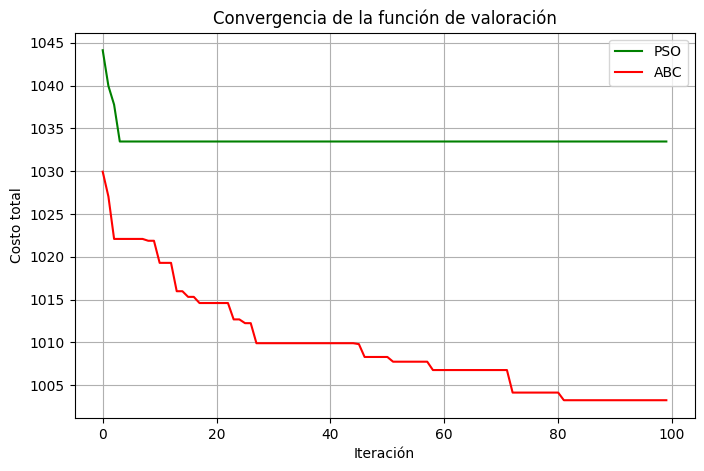

In [167]:
# Parametros

n_destinos = 20
deposito = [5,5]

gen = InstanceGenerator(n_destinos, deposito)
coords = gen.generate_coordinates()
G = gen.build_dynamic_graph(coords)

coords_map = {0:tuple(deposito)}
for i,(x,y) in enumerate(coords, start=1):
    coords_map[i] = (x,y)

# PSO

pso = PSO_TSP(G)
ruta_pso, cost_pso, history_pso = pso.optimize(return_history=True)
print(f"Costo de PSO: {cost_pso:.2f}")


abc = ABC_TSP(G)
ruta_abc, cost_abc, history_abc = abc.optimize(return_history=True)
print(f"ABC cost: {cost_abc:.2f}")


 # Mostrar gráfico de convergencia
plt.figure(figsize=(8, 5))
plot_convergence(history_pso, "PSO", "green")
plot_convergence(history_abc, "ABC", "red")
plt.show()

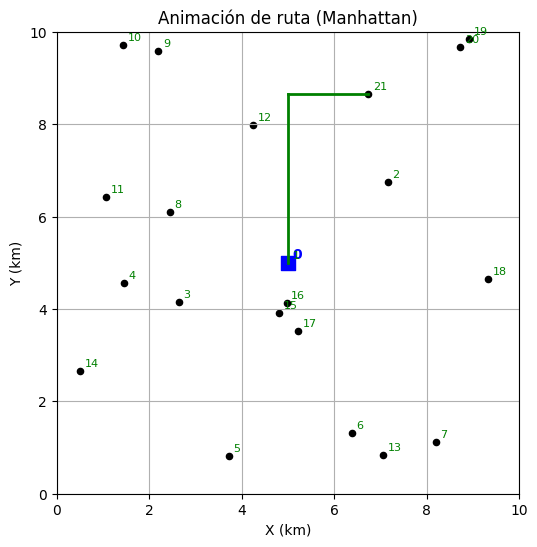

In [161]:
anim = make_animation(coords_map, ruta_pso, deposito=[5,5], pause=500)# Animacion PSO
HTML(anim.to_jshtml())

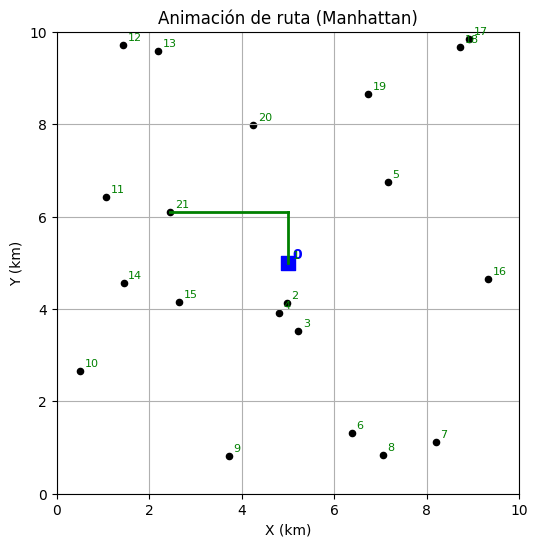

In [160]:
anim2 = make_animation(coords_map, ruta_abc, deposito=[5,5], pause=500)
HTML(anim2.to_jshtml())

# Evaluación y Comparación de Algoritmos
A continuación se correrá cada algoritmo múltiples veces, se recolectarán métricas de desempeño y se compararán estadísticamente.

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# Configuración de reproducibilidad
np.random.seed(0)


In [ ]:
def evaluar_algoritmo(func, data, n_runs=30, **kwargs):
    tiempos = []
    resultados = []
    for i in range(n_runs):
        start = time.time()
        res = func(data, **kwargs)
        end = time.time()
        tiempos.append(end - start)
        resultados.append(res)
    return {
        'tiempos': np.array(tiempos),
        'resultados': np.array(resultados),
        'media_tiempo': np.mean(tiempos),
        'std_tiempo': np.std(tiempos),
        'media_resultado': np.mean(resultados),
        'std_resultado': np.std(resultados)
    }


In [ ]:
# Supongamos que hay funciones algoritmo1 y algoritmo2 definidas y datos 'dataset'
n_runs = 50
exp1 = evaluar_algoritmo(algoritmo1, dataset, n_runs=n_runs)
exp2 = evaluar_algoritmo(algoritmo2, dataset, n_runs=n_runs)

# Reunir en DataFrame
df = pd.DataFrame({
    'algoritmo': ['algoritmo1']*n_runs + ['algoritmo2']*n_runs,
    'tiempo': np.concatenate([exp1['tiempos'], exp2['tiempos']]),
    'resultado': np.concatenate([exp1['resultados'], exp2['resultados']])
})
df.head()


In [ ]:
# Estadísticas resumen
resumen = df.groupby('algoritmo').agg(
    media_tiempo=('tiempo', 'mean'),
    std_tiempo=('tiempo', 'std'),
    media_resultado=('resultado', 'mean'),
    std_resultado=('resultado', 'std')
).reset_index()
resumen


In [ ]:
# Boxplot de tiempos
plt.figure()
df.boxplot(column='tiempo', by='algoritmo')
plt.title('Comparación de Tiempos')
plt.suptitle('')
plt.ylabel('Segundos')

# Boxplot de resultados
plt.figure()
df.boxplot(column='resultado', by='algoritmo')
plt.title('Comparación de Resultados')
plt.suptitle('')
plt.ylabel('Valor de Salida')
plt.show()


## Conclusiones
- Describir cuál algoritmo es más rápido en promedio y cuánta variabilidad presenta.
- Comparar la calidad o valor de salida promedio.
- Realizar pruebas adicionales modificando parámetros si es necesario para validar la robustez.